Copyright: aiCTX AG, 2019

<div class="report-header"><div class="aictx-logo"></div>
<span class="report-type">Tutorial</span><br />
<span class="report-author">Author: Felix Bauer</span><br />
<span class="report-date">28th May, 2019</span>
</div><h1>Tutorial:</h1><h1>Reservoir Computing on DynapSE</h1>

In this tutorial we will implement a reservoir network on the DynapSE which can be used to detect a specific pattern in the input signal.

<br>

## Task: Detect missing pulse

Our input consists of a sequence of equidistant pulses of some fixed width. However, every fourth pulse is omitted. The input can therefore be divided into periods consisting of three pulses and one longer gap each. 

In a slight modification of this, also the second pulse within a period is omitted. The task of the reservoir will be to detect this modification.

This task is inspired by the detection of anomalies in an ECG signal, which may consist of a missing peak. It is complex because the reservoir dynamics need to cover different time scales. On the one hand the pulses need to be detected. On the other hand, for each longer gap between pulses the reservoir needs to contain information whether this is after the third pulse within a period or after the first one, where there should be no gap. Therefore memory needs to last over a significant part of the input period, which is on a longer time scale than the individual pulses.

<br>

### Input to reservoir

To generate the input signal we can use the `SignalGen` class:

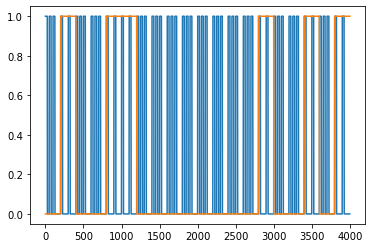

In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline  

import matplotlib
from matplotlib import pyplot as plt
%aimport tutorial
import numpy as np

signal_gen = tutorial.SignalGen(
    width_pulse=25,
    period=200,
    p_abnormal=0.2,
)

signal_training, tgt_training = signal_gen(100)
signal_test, tgt_test = signal_gen(20)


plt.plot(signal_test)
plt.plot(tgt_test)

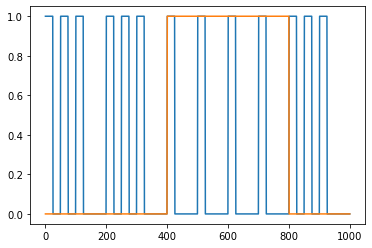

In [2]:
plt.plot(signal_test[400:1400])
plt.plot(tgt_test[400:1400])

### Encoding in spikes
We will use a delta-algorithm that emits spikes on channel 0 when the signal increases and on channel 1 when it decreases. For the type of signal we will be using, the function `signal_to_spikes` will do the job:

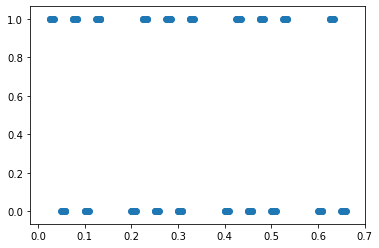

In [3]:
times_training, channels_training = tutorial.signal_to_spikes(
    signal_training, spikes_per_edge=10, ts_per_spike=1, dt=0.001
)
times_test, channels_test = tutorial.signal_to_spikes(
    signal_test, spikes_per_edge=10, ts_per_spike=1, dt=0.001
)

plt.scatter(times_training[:200], channels_training[:200])

## Network

### Architecture
We will split our reservoir into three neuron populations:
- Input, 64 neurons, to increase dimensionality of signal
- Recurrent exciratory, 256 neurons
- Inhibitory, 64 neurons
Each population will be implemented on a different core, so that we can tune biases individually. 

To implement this network on the chip and later also to send data and record activities, we will use the `DynapseControl` class, which provides a few useful methods and automatically connects to cortexcontrol. For more detailled information about connecting to cortexcontrol, see the `DynapseControl-ctx.ipynb` notebook.

Make sure you have cortexcontrol running with an open RPyC connection.

### Biases
The reservoir needs long memory but also should detect quick changes in the signal. This suggests a broad distribution of synaptic and neural time constants in the recurrent population. For the input we can have shorter time constants.
The file `biases.py` contains a set of biases that match these requirements. In general these biases should work independently of the individual chip but some fine tuning may be required.

In [4]:
from dynapse_control import DynapseControl, rectangular_neuron_arrangement

# - Parameters
# Neuron population sized
size_in = 64
size_rec = 256
size_inhib = 64
size_total = size_in + size_rec + size_inhib

# Arrangement of neurons on chip
firstid_in = 52
firstid_rec = 256
firstid_inhib = 529
width_in = 8
width_rec = 16
width_inhib = 8
# - IDs of neurons to be used
ids_in = rectangular_neuron_arrangement(firstid_in, size_in, width_in)
ids_rec = rectangular_neuron_arrangement(
    firstid_rec, size_rec, width_rec
)
ids_inhib = rectangular_neuron_arrangement(
    firstid_inhib, size_inhib, width_inhib
)
ids_all = np.array(ids_in + ids_rec + ids_inhib)

# Virtual neurons: one for each input channel (do not use neuron 0)
ids_virtual = np.array([1, 2])

# DynapseControl object (clear first 3 cores)
dc = DynapseControl(clearcores_list = range(3))
# Load biases and silence neurons that are still firing
dc.load_biases('biases.py')
dc.silence_hot_neurons(ids_all, 5)

dynapse_control: RPyC connection established through port 1300.
dynapse_control: Already initialized chips: [0, 1, 2, 3]
dynapse_control: RPyC namespace complete.
dynapse_control: Chips  have been cleared. Chips 0 had been cleared previously.
dynapse_control: RPyC connection has been setup successfully.
DynapseControl: Initializing DynapSE
DynapseControl: Spike generator module ready.
DynapseControl: Poisson generator module ready.
DynapseControl: Time constants of cores [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] have been reset.
DynapseControl: Neurons initialized.
	 4092 hardware neurons and 1023 virtual neurons available.
DynapseControl: Neuron connector initialized
DynapseControl: Connectivity array initialized
DynapseControl: Connections to cores [0 1 2] have been cleared.
DynapseControl: FPGA spike generator prepared.
DynapseControl ready.
DynapseControl: Biases have been loaded from biases.py.
DynapseControl: Collecting IDs of neurons that spike within the next 5 seconds


[302, 420, 453]

If you need to tune biases manually, `DynapseControl` provides a few useful methods, such as `measure_firing_rates`, `monitor_firing_rates` and `sweep_freq_measure_rate`.

<br>

### Connections

For setting synaptic connections we need to keep in mind that for each neuron fan in is limited to 64. 

<br>

#### External (virutal) to input neurons
Each input neuron will have a randomly chosen, even number of input connecitons between 2 and 64. Half of those connect to input channel 0 the other half to input channel 1, with opposite sign. Signs are chosen randomly. Note that for setting connections with virtual presynaptic neurons, we can use the same method as for hardware neurons. We just need to set the `virtual_pre` argument to `True`:

In [5]:
# - Generate input weight matrix
nums_connections = np.random.randint(1, 33, size=(1, size_in))
# Randomly flip sign
weights_0 = nums_connections * np.random.choice(
    (-1, 1), size=size_in
)
weights_in = np.zeros((2, size_in))
weights_in[0, :] = weights_0
weights_in[1, :] = -1 * weights_0  # Flip sign for channel 1

# Set connections in cortexcontrol
dc.set_connections_from_weights(
    weights=weights_in,
    neuron_ids=ids_virtual,
    neuron_ids_post=ids_in,
    syn_exc=dc.syn_exc_fast,
    syn_inh=dc.syn_inh_fast,
    virtual_pre=True,
    apply_diff=False,
)

DynapseControl: Excitatory connections of type `FAST_EXC` between virtual and hardware neurons have been set.
DynapseControl: Inhibitory connections of type `FAST_INH` between virtual and hardware neurons have been set.


#### Connections to recurrent
Each neuron of the recurrent population receives input from 16 randomly chosen input neurons, 16 inhibitory neurons and 32 other excitatory neurons.

<br>

#### Connections to inhibitory
Each inhibitory neuron has presynaptic connections to 64 randomly chosen excitatory neurons.

For more flexibility in tuning parameters, the connections from input to recurrent groups have a different synapse type than the rest.

<br>

Note the following details
* We use the same method as with the virtual neurons above. We just don't set `virtual_pre` to `True`, to connect between two populations of hardware neurons.
* In some lines we use the `add_connections_from_weights` method instead of `set_...`. This way we do not overwrite existing connections to the postsynaptic neurons. _We could have also use_ `add_...` _right from the beginning, since there were no previous connections that we would have needed to overwrite._
* When we set the recurrent connections, we omit the `neuron_ids_post` argument. This means, that the presynaptic neuron population is the same as the postsynaptic (i.e. we get generate connections).
* In the last call of the method, `apply_diff` is `True`. This means that the changes are actually applied to the hardware. It is more efficient to set this parameter to `True` only at the end, when the changes should take effect, and not during each call of the `add_connections...` method.
* When setting connections, `DynapseControl` will automatically test whether connection aliasing occurs. By default it will raise an exception in such case. This can be oppressed by passing `prevent_aliasing=False` as argument to the corresponding methods.
- The `DynapseControl` class keeps track of which (internal and external) synaptic connections have been set, also considering aliasing. 3D-connectivity matrices can be accessed through the attributes `connections` and `connections_virtual`. Furthermore, the `get_connections` method returns connectivity matrices for specific pre- and postsynaptic neurons and synapse types. In all cases, the first axis corresponds to different synapse types, second and third axis to pre- and postsynaptic neurons.
- The order of synapse types in the first axis of the connectivity matrices is `fast_exc`, `slow_exc`, `fast_inh`, `slow_inh`.

In [6]:
# - Weight matrix from input to recurrent
weights_in_rec = np.zeros((size_in, size_rec))
for col in weights_in_rec.T:
    input_choice = np.random.choice(size_in, size=16, replace=True)
    for row in input_choice:
        col[row] += 1

# - Weight matrix recurrent
weights_rec = np.zeros((size_rec, size_rec))
for col in weights_rec.T:
    input_choice = np.random.choice(size_rec, size=32, replace=True)
    for row in input_choice:
        col[row] += 1

# - Weight matrix recurrent to inhibitory
weights_rec_inhib = np.zeros((size_rec, size_inhib))
for col in weights_rec_inhib.T:
    input_choice = np.random.choice(size_rec, size=64, replace=True)
    for row in input_choice:
        col[row] += 1

# - Weight matrix inhibitory to recurrent
weights_inhib_rec = np.zeros((size_inhib, size_rec))
for col in weights_inhib_rec.T:
    input_choice = np.random.choice(size_inhib, size=16, replace=True)
    for row in input_choice:
        col[row] -= 1


# - Set connections in cortexcontrol
# From input neurons to excitatory neurons
dc.set_connections_from_weights(
    weights=weights_in_rec,
    neuron_ids=ids_in,
    neuron_ids_post=ids_rec,
    syn_exc=dc.syn_exc_fast,
    syn_inh=dc.syn_inh_fast,
    apply_diff=False,
)

# From excitatory neurons to excitatory neurons
dc.add_connections_from_weights(
    weights=weights_rec,
    neuron_ids=ids_rec,
    syn_exc=dc.syn_exc_slow,
    syn_inh=dc.syn_inh_fast,
    apply_diff=False,
)

# From excitatory neurons to inhibitory neurons
dc.set_connections_from_weights(
    weights=weights_rec_inhib,
    neuron_ids=ids_rec,
    neuron_ids_post=ids_inhib,
    syn_exc=dc.syn_exc_slow,
    syn_inh=dc.syn_inh_fast,
    apply_diff=False,
)

# From inhibitory neurons to excitatory neurons
dc.add_connections_from_weights(
    weights=weights_inhib_rec,
    neuron_ids=ids_inhib,
    neuron_ids_post=ids_rec,
    syn_exc=dc.syn_exc_slow,
    syn_inh=dc.syn_inh_fast,
    apply_diff=True,
)

# - Request connectivity matrices between neurons and for external connections
print("Connections external:")
print(dc.get_connections(ids_virtual, ids_in, virtual_pre=True))
print("Connections from first few recurrent to first few inhibitory neurons:")
print(dc.get_connections(ids_rec[:5], ids_inhib[:3], syn_types=1))

DynapseControl: Excitatory connections of type `FAST_EXC` between hardware neurons have been set.
DynapseControl: Inhibitory connections of type `FAST_INH` between hardware neurons have been set.
DynapseControl: Excitatory connections of type `SLOW_EXC` between hardware neurons have been set.
DynapseControl: Inhibitory connections of type `FAST_INH` between hardware neurons have been set.
DynapseControl: Excitatory connections of type `SLOW_EXC` between hardware neurons have been set.
DynapseControl: Inhibitory connections of type `FAST_INH` between hardware neurons have been set.
DynapseControl: Excitatory connections of type `SLOW_EXC` between hardware neurons have been set.
DynapseControl: Inhibitory connections of type `FAST_INH` between hardware neurons have been set.
DynapseControl: Connections have been written to the chip.
Connections external:
[[[13 25  0  0 19  0  1  1  0  0  8  0  0  5  0  0  0 27 32 32 19  0  0
   31  0 32 16  0  0  3 27 11  0 18  0  0 21  0  0  0  3  0 19 

## Sending and recording data

To obtain data for training and testing a readout layer, you can use the `send_arrays` method of the `DynapseControl` class. It allows sending an input and recording the neuron activities at the same time.
Here, the `neuron_ids` are the IDs of the neurons that will appear as the origin of the events we are sending to the chip. We will set them to the virtual neurons. An event at channel `n` will then correspond to the `n`-th virtual neuron. The arguments `targetchip_id` and `targetcore_mask` determine, which chip and which cores receive the events.

Note: You can only send 2&ast;&ast;16-1 input spikes to the chip at once. Our training and test data are sufficiently small. In other cases it may be necessary to split the data into batches.

By the way, if you only want to record activities, without sending data, use the `record` function.

In [7]:
# - Training data
times_training_out, channels_training_out = dc.send_arrays(
    channels=channels_training,
    times=times_training,
    virtual_neur_ids=ids_virtual,  # IDs of neurons that appear as sender of the events.
    t_record=times_training[-1] + 0.5, # Record until 0.5s after end of training data
                                       # to capture subsequent activity
    record_neur_ids=ids_all, # IDs of neurons that should be recorded
    targetchip_id=0,
    targetcore_mask=15,
    record=True,
)

DynapseControl: Generating FPGA event list from arrays.
DynapseControl: Stimulus prepared from arrays.
DynapseControl: Stimulus preloaded.
DynapseControl: Updated existing buffered event filter.
DynapseControl: Started stimulation for 20.434 s.
	Recorded 1480541 event(s) and 1 trigger event(s)
		 Using trigger event 0
DynapseControl: Extracted event data


In [8]:
# - Test data
times_test_out, channels_test_out = dc.send_arrays(
    channels=channels_test,
    times=times_test,
    virtual_neur_ids=ids_virtual,  # IDs of neurons that appear as sender of the events.
    t_record=times_test[-1] + 0.5, # Record until 0.5s after end of test data
                                   # to capture subsequent activity
    record_neur_ids=ids_all, # IDs of neurons that should be recorded
    targetchip_id=0,
    targetcore_mask=15,
    record=True,
)

DynapseControl: Generating FPGA event list from arrays.
DynapseControl: Stimulus prepared from arrays.
DynapseControl: Stimulus preloaded.
DynapseControl: Updated existing buffered event filter.
DynapseControl: Started stimulation for 4.434 s.
	Recorded 282928 event(s) and 1 trigger event(s)
		 Using trigger event 0
DynapseControl: Extracted event data


Scatter plot of the recorded data:

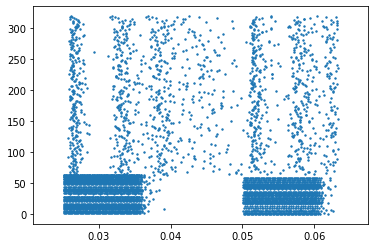

In [9]:
plt.scatter(times_test_out[:5000], channels_test_out[:5000], s=2)

## Readout

You can now train a linead readout to detect the missing pulses in the signal. For obtaining an analog signal instead of spikes, one could low-pass filter them, for instance. All this can be done independently of the modules shown here and is therefore not part of this tutorial.